# Machine Learning sobre OkC

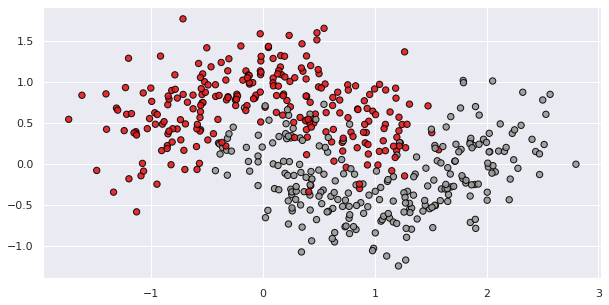

In [ ]:
#@markdown ## Machine Learning IV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

fig, ax = plt.subplots(figsize=(10,5))
sctr = ax.scatter(X[:,0],X[:,1], c=y, edgecolor='black', s=40, alpha=0.9,
                 cmap=plt.cm.Set1)

- Repaso
- Dataset OkCupid
- Preparación de los datos: 
  - Imputación de nulos
  - Feature Selection
  - Feature Engineering
- Aprendizaje Supervizado
  - Generalizacion y overfitting
    train, test split
    validation curve
  - Regresión Lineal
  - KNN 
  - Árbol de decisión
  - Ensambles de Árboles
  - Regresión Logística
- Complejidad vs Interpretabilidad
- Aprendizaje No supervisado
  - Clustering, *KMeans*
  - PCA

In [ ]:
# Datos scrapeados y provistos por Mathias Gatti :D 
!wget -nc https://unket.s3-sa-east-1.amazonaws.com/data/ok_cupid_data.csv

In [ ]:
import pandas as pd

df = pd.read_csv('ok_cupid_data.csv', index_col=0).drop(['user_id', 'id'], axis=1)
df.shape

(39350, 3323)

In [ ]:
df.sample(5)

,How does the idea of being slapped hard in the face during sex make you feel?,Divide your age by 2. Have you had sex with at least that many people?,Would you date someone just for the sex?,Do you read erotic fiction?,Is it wrong to watch pornographic films if you're in a relationship?,Would you watch a porno movie with your ideal match?,Have you ever owned sex toys?,Which is a bigger deal for you?,Would you dump someone simply because they weren't good at sex?,Would you rather…,Group sex (with 3 or more people)?:,Do you like kissing in public?,"Regardless of future plans, what's more interesting to you right now?",How old were you when you lost your virginity?,Would you ever take your family to a nude beach?,How important is religion/God in your life?,"Do you believe in some kind of a spiritual, cosmic force outside the realm of most modern religion?",Some religions are more correct than others.,Do you believe in ghosts?,"Would you prefer good things happened, or interesting things?",Which would you rather be?,Which word describes you better?,Have you ever seen a therapist?,Do you think really abstract art—like just splattered paint—can be truly brilliant?,"When something upsets you, what do you become more of?","When telling stories, do you like to exaggerate?","Which, on you, is closest to perfection?",Does the idea of flipping a coin to make important life decisions appeal to you?,Do you like to argue?,Have you ever cried during a movie?,Which describes you better?,Are you a better conversationalist or listener?,"When in charge of others, how do you tend to be?",Which word describes you better?.1,Which is more important in a healthy relationship?,Do you have a problem with racist jokes?,Are you a highly skilled writer?,Are you more of a fast or careful talker?,Would you rather live in the big city or a small town?,Do you spend more money on clothes or food?,...,"When sharing a bed, do you share a duvet?",What’s the most important part of Diwali to you?,Do you create your own recipes or follow recipes?,Do you watch morning gossip shows?,Rajnikant or Chiranjeevi?,Should characters be allowed to kiss on shows?,Do you know anyone who has married someone they met on a dating app?,"Do you like true crime shows, podcasts, books, etc.?",Are you on Eksi Sozluk?,Do you like Papa Francesco?,Is mental health as important as physical health?,Do you have more than one job?,Should women be responsible for running the household and raising children?,In Vietnam what is the best measure of success?,Do you volunteer?,Are you in favor of the legalization of recreational cannabis?,What is your comfort food?,Should there be public transportation on Shabbat?,Is champagne only for special occasions?,Would you go on a virtual double date with a friend?,Youth movements are...,Do you find it attractive when a match advocates for social and political issues on social media?,How important are horoscopes to you when it comes to marriage?,Meyhane or bar?,Do you like to go Dutch on dates?,Did you ever bunk school as a kid?,Would you date someone who doesn’t support their local hockey team during the playoffs?,"If you’re dating someone, would you tell your parents about them?",Which Netflix show is better?,Would you rather eat Pizza or Churrasco?,Where would you rather go on a summer holiday?,Do you like going to Oktoberfest?,What do you prefer to drink on a night out?,Ranbir or Ranveer?,When you are fasting do you dislike it when someone nearby is eating or drinking?,title,rawContent,__typename,location,age
1965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A perfect day,"Brunch on a patio somewhere, afternoon with dr...",Essay,"Toronto, Canada",27
34494,NaN,NaN,1.0,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,0.

# Tipos de ML


<center><img src=https://github.com/institutohumai/cursos-python/raw/ml0/MachineLearning/media/tipos_modelos.png width=500></center>

Ejemplos Supervisados:

Clasificación: 
 - la persona va o no a terapia?
 - de qué país es?
 
Regresión:
 - cuántos años tiene la persona? (dadas las preguntas)

Todo este repertorio de estimadores va a usar la misma inferfaz, o API, que se ve algo así:

```python
from sklearn.familia_de_modelos import Modelo
mi_modelo = Modelo(hiperparámetros)
mi_modelo.fit(X, y)

predicción = mi_modelo.predict(nuevo_X)
```

Para ajustar nuestros modelos de machine learning, la función de sklearn toma una matriz de features **X** y un vector **y** (en el caso de ML supervisado), donde **X** tiene la forma ``(n_observaciones, n_variables)`` e **y** ``(n_observaciones)``

El pipeline suele ser:

- Selección de una clase de modelo, importandolo como corresponda de Scikit-learn  

- Selección de los hiperparámetros del modelo, instanciando esa clase con los valores deseados  

- Ordenamiento de los datos en una matriz de features y un vector *target*. Esto incluye carga de los datos, ordenarlos y concatenarlos, descartar y/o llenar nulos, crear nuevas variables o normalizar.

- *Fitteo* del modelo a los datos, usando el método fit() de la instancia del modelo.  

Aplicación del modelo a nuevos datos:  
- Para supervisado, predecimos categorias usando predict()
- Para no supervisado, usamos transform() o predict() dependiendo del caso

## Preparación

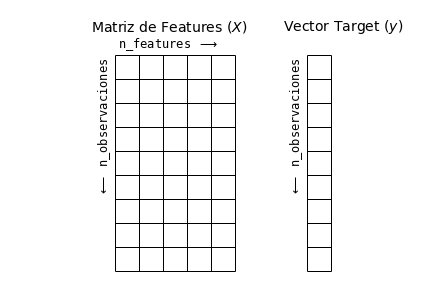

In [ ]:
#@title Matriz de Features

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.axis('equal')

# Draw features matrix
ax.vlines(range(6), ymin=0, ymax=9, lw=1)
ax.hlines(range(10), xmin=0, xmax=5, lw=1)
font_prop = dict(size=12, family='monospace')
ax.text(-1, -1, "Matriz de Features ($X$)", size=14)
ax.text(0.1, -0.3, r'n_features $\longrightarrow$', **font_prop)
ax.text(-0.1, 0.1, r'$\longleftarrow$ n_observaciones', rotation=90,
        va='top', ha='right', **font_prop)

# Draw labels vector
ax.vlines(range(8, 10), ymin=0, ymax=9, lw=1)
ax.hlines(range(10), xmin=8, xmax=9, lw=1)
ax.text(7, -1, "Vector Target ($y$)", size=14)
ax.text(7.9, 0.1, r'$\longleftarrow$ n_observaciones', rotation=90,
        va='top', ha='right', **font_prop)

ax.set_ylim(10, -2);

Definimos nuestra variable objetivo y cuáles son nuestras features o variables explicativas:

In [ ]:
no_preguntas = ['title','rawContent','__typename','location', 'age']

In [ ]:
col_regresion = 'age'
y_r = df[col_regresion]

In [ ]:
df.loc[:, preguntas].isnull().sum()

How does the idea of being slapped hard in the face during sex make you feel?        27049
Divide your age by 2.  Have you had sex with at least that many people?              28387
Would you date someone just for the sex?                                             15630
Do you read erotic fiction?                                                          33071
Is it wrong to watch pornographic films if you're in a relationship?                 31557
                                                                                     ...  
Where would you rather go on a summer holiday?                                       39024
Do you like going to Oktoberfest?                                                    38193
What do you prefer to drink on a night out?                                          39322
Ranbir or Ranveer?                                                                   39212
When you are fasting do you dislike it when someone nearby is eating or drinking?    39346

## Imputación de nulos

In [ ]:
preguntas = [c for c in df.columns if c not in no_preguntas]
df.loc[:, preguntas].isnull().sum(axis=0)

How does the idea of being slapped hard in the face during sex make you feel?        27049
Divide your age by 2.  Have you had sex with at least that many people?              28387
Would you date someone just for the sex?                                             15630
Do you read erotic fiction?                                                          33071
Is it wrong to watch pornographic films if you're in a relationship?                 31557
                                                                                     ...  
Where would you rather go on a summer holiday?                                       39024
Do you like going to Oktoberfest?                                                    38193
What do you prefer to drink on a night out?                                          39322
Ranbir or Ranveer?                                                                   39212
When you are fasting do you dislike it when someone nearby is eating or drinking?    39346

In [ ]:
# numero de respuestas por pregunta
n_respuestas_por_pregunta = df.loc[:, preguntas].sum(axis=0) 

# descartamos la parte con menos respuestas
cuantil_umbral = 0.95  # pensar, cuál es el tradeoff aca?
descartar = n_respuestas_por_pregunta[(n_respuestas_por_pregunta < n_respuestas_por_pregunta.quantile(cuantil_umbral))].index

df = df.loc[:, [c for c in df.columns if c not in descartar]]

df.shape

(39350, 171)

In [ ]:
df.sample(5)

,Would you date someone just for the sex?,Would you rather…,Group sex (with 3 or more people)?:,"Regardless of future plans, what's more interesting to you right now?",How important is religion/God in your life?,Which would you rather be?,Which word describes you better?,Do you like to argue?,Are you a morning person?,How frequently do you drink alcohol?,What's your relationship with marijuana?,What's your deal with harder drugs (stuff beyond pot)?,"How much do you go ""clubbing"" (out dancing in bars)?",Have you ever been married?,Do you have any tattoos?,Choose the better romantic activity:,Pick the best date on this list:,Should burning your country's flag be illegal?,Do you believe in God?,Do you like to watch sports on television?,Do you think humans have enough respect for the Earth's other species?,What's the highest level of education you've completed?,How important is money/wealth for you in a match?,"If you don't do anything at all for an entire day, how does that make you feel?",Have you smoked a cigarette in the last 6 months?,Is marriage a necessity for two people who love each other?,Are you a cat person or a dog person?,How often do you use profane language?,"In a serious relationship, do you feel it's important to keep your significant other informed of the details of your day-to-day life?","What is next in this series? 1, 4, 10, 19, 31, _",Is jealousy healthy in a relationship?,How would you describe your body?,Which best describes your personal feelings about sports?,"On average, which best describes how often you GET WICKED DRUNK?",Are you currently employed?,Would you ever date or mess around with a good friend's ex?,Biting?,Could you date someone who does drugs?,"How often should your significant other buy you gifts, jewelry, or other things more expensive than, say, dinner, cards, or flowers?","Once you're intimate, how often would you and your significant other have sex?",...,Are you looking for a partner to have children with?,"When you first talk online with someone, which of the following would you prefer to talk about?",Which pubic hair style do you prefer for a partner?,Are you generally able to forgive and forget?,Are you Christian?,What's worse on a first date?,Are you either vegetarian or vegan?,Which best describes your political beliefs?,How often do you use social media?,How often do you give Facebook updates?,How often do you masturbate?,How often do you wear cologne or perfume?,"Who are you most likely to reveal a dark, provocative secret to?",Which is scarier to reveal to a new partner?,Is it possible for your partner to reveal too much information?,Do you ever Skype/call/video chat a date you met online before meeting up in person?,Would you introduce someone you've started seeing casually to your friends?,Do you like using party drugs like MDMA/molly?,What is your preferred cuddling position?,Are you kinky?,Do you smoke?.1,Would you date someone who was in considerable debt?,Should the US build a wall between the US & Mexico?,"Are you open to a casual relationship (i.e. more than a hookup, less than a significant other)?",Do you believe guns should be allowed in schools?,"If you see an attractive stranger (offline), do you introduce yourself?",Can you tell from someone’s dating profile whether or not you’ll get along in real life?,What's your Hogwarts house?,How would you feel if your partner earned more money than you?,How often do you go to a place of worship?,Is it important to you that your partner practices the same religion as you?,Do you answer work email on the weekend?,How often do you take selfies?,Best first date?,How will you address racial inequality?,title,rawContent,__typename,location,age
25900,0.0,3.0,NaN,0.0,3.0,NaN,0.0,NaN,0.0,2.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,0.0,2.0,NaN,NaN,0.0,NaN,1.0,NaN,NaN,2.0,...,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
X = df.fillna(df.median(skipna=True))
y_c = y_c.fillna(y_c.median(skipna=True))

In [ ]:
X.sample(5)

,Would you date someone just for the sex?,Would you rather…,Group sex (with 3 or more people)?:,"Regardless of future plans, what's more interesting to you right now?",How important is religion/God in your life?,Which would you rather be?,Which word describes you better?,Do you like to argue?,Are you a morning person?,How frequently do you drink alcohol?,What's your relationship with marijuana?,What's your deal with harder drugs (stuff beyond pot)?,"How much do you go ""clubbing"" (out dancing in bars)?",Have you ever been married?,Do you have any tattoos?,Choose the better romantic activity:,Pick the best date on this list:,Should burning your country's flag be illegal?,Do you believe in God?,Do you like to watch sports on television?,Do you think humans have enough respect for the Earth's other species?,What's the highest level of education you've completed?,How important is money/wealth for you in a match?,"If you don't do anything at all for an entire day, how does that make you feel?",Have you smoked a cigarette in the last 6 months?,Is marriage a necessity for two people who love each other?,Are you a cat person or a dog person?,How often do you use profane language?,"In a serious relationship, do you feel it's important to keep your significant other informed of the details of your day-to-day life?","What is next in this series? 1, 4, 10, 19, 31, _",Is jealousy healthy in a relationship?,How would you describe your body?,Which best describes your personal feelings about sports?,"On average, which best describes how often you GET WICKED DRUNK?",Are you currently employed?,Would you ever date or mess around with a good friend's ex?,Biting?,Could you date someone who does drugs?,"How often should your significant other buy you gifts, jewelry, or other things more expensive than, say, dinner, cards, or flowers?","Once you're intimate, how often would you and your significant other have sex?",...,Are you looking for a partner to have children with?,"When you first talk online with someone, which of the following would you prefer to talk about?",Which pubic hair style do you prefer for a partner?,Are you generally able to forgive and forget?,Are you Christian?,What's worse on a first date?,Are you either vegetarian or vegan?,Which best describes your political beliefs?,How often do you use social media?,How often do you give Facebook updates?,How often do you masturbate?,How often do you wear cologne or perfume?,"Who are you most likely to reveal a dark, provocative secret to?",Which is scarier to reveal to a new partner?,Is it possible for your partner to reveal too much information?,Do you ever Skype/call/video chat a date you met online before meeting up in person?,Would you introduce someone you've started seeing casually to your friends?,Do you like using party drugs like MDMA/molly?,What is your preferred cuddling position?,Are you kinky?,Do you smoke?.1,Would you date someone who was in considerable debt?,Should the US build a wall between the US & Mexico?,"Are you open to a casual relationship (i.e. more than a hookup, less than a significant other)?",Do you believe guns should be allowed in schools?,"If you see an attractive stranger (offline), do you introduce yourself?",Can you tell from someone’s dating profile whether or not you’ll get along in real life?,What's your Hogwarts house?,How would you feel if your partner earned more money than you?,How often do you go to a place of worship?,Is it important to you that your partner practices the same religion as you?,Do you answer work email on the weekend?,How often do you take selfies?,Best first date?,How will you address racial inequality?,title,rawContent,__typename,location,age
23286,0.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,2.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,...,1.0,2.0,3.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,3.0,2.0,2.0,1.0,0.0,0.0,2.0,3.0,1.0,2.0,2.0,0.0,2.0,1.0,3.0

In [ ]:
from sklearn.model_selection import train_test_split

# Dividimos los datos en un 30% por cada set
X_train, X_test, y_train_r, y_test_r = train_test_split(X, y_r, random_state=0, train_size=0.3)

## Aprendizaje Supervisado

### Regresión Lineal

En estadística, la regresión lineal o es un modelo matemático usado para aproximar la relación de dependencia entre una variable dependiente $y$, y  $X$. Este modelo puede ser expresado a grandes rasgos como:

$$y=\beta_0+\beta_1x_1$$


Importamos la clase de estimador apropiado de Scikit-Learn, en este caso el de regresión lineal:

In [ ]:
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()

In [ ]:
modelo.fit(X_train.drop(no_preguntas + [col_regresion], axis=1), y_train_r) # se calculan los pesos optimos, de mejor ajuste

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


<img width='600px' src='https://dphi.tech/blog/wp-content/uploads/2020/04/example-regression-simulation.gif'></img>


donde:

* <math>Y</math> es la variable dependiente o variable de respuesta.
* $x$, es las variables explicativas, independientes o regresoras. Podemos tener cualquier número.
* $\beta_0,\beta_1$ son los parámetros del modelo, miden la influencia que las variables explicativas tienen sobre la variable objetivo.

el término $\beta_0$ es la intersección o término "constante", las $\beta_i $ son los parámetros respectivos a cada variable independiente. 

Una vez entrenado el modelo, podemos intepretar el valor de los coeficientes. 

El caracter $\overline{y}$ es el promedio y $\hat{y}$ la estimación.

El Error Absoluto Medio es el promedio de las diferencias absolutas entre los valores estimados y los reales:

$$MAE = \frac{1}{n}\sum_{i=1}^{n}\left | y_{i} - \hat{y_{i}} \right |$$

En lugar de usar el valor absoluto, podemos usar la diferencia al cuadrado.

$$MSE = \frac{1}{n}\sum_{i=1}^{n}\left ( y_{i} - \hat{y_{i}} \right )^2$$

El R^2 nos dice la proporción de varianza que es explicada por nuestro modelo. Es la suma de las diferencias de nuestro modelo, sobre la suma de cuadrados de la variable original (la varianza).

$$R^2 = \sum_{i=1}^{n} \frac{( y_{i} - \hat{y_{i}}^2)}{( y_{i} - \overline{{y_{i}}}^2)}$$

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

datos = zip(modelo.coef_, X.columns)
datos = sorted(datos, key=lambda x: x[0])
colors = ['Positivo' if c[0] > 0 else 'Negativo' for c in datos]
x, y = [c[0] for c in datos], [c[1] for c in datos]

fig = px.bar(
    x=x, 
    y=y, 
    color=colors,
    color_discrete_sequence=['red', 'blue'],
    labels=dict(x='Variable', y='Coeficiente'),
    title='Peso para cada variable al predecir', 
    orientation='h',
)
fig.show()

### Clasificación

Dentro el mundo del aprendizaje supervisado, los modelos de clasificación surgen para casos en los que la variable objetivo no es contínua -como teníamos en la regresión lineal- sino que es **categórica**. De esta manera, como su nombre lo indica, el modelo entrenado va a trabajar para predecir si un dato nuevo va a pertenecer a una u otra categoría. 
 

### Matriz de confusión


2021-06-16 20:58:39 URL:https://datasets-humai.s3.amazonaws.com/datasets/sentiment.csv [125932/125932] -> "sentiment.csv.1" [1]
Accuracy: 0.8561151079136691


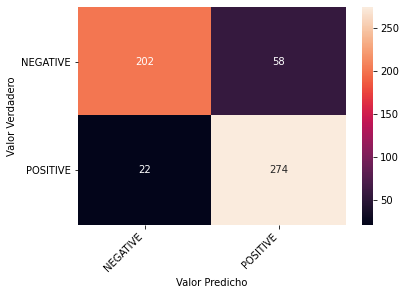

In [ ]:
# Importamos 
#@title Ejemplo: clasificador de opiniones de clases
 
!wget -nv https://datasets-humai.s3.amazonaws.com/datasets/sentiment.csv 
 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
 
df = pd.read_csv('sentiment.csv')
df.head()
 
# separamos train y test
X, y = df.iloc[:, 1], df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
 
# Vectorizamos los textos por TF-IDF
vec = TfidfVectorizer(min_df=3)
model = MultinomialNB()
clf = make_pipeline(vec,model)
 
clf = clf.fit(X_train, y_train)
 
predictions = clf.predict(X_test)
print('Accuracy:', sum(predictions == y_test) / len(y_test))
df_cm = confusion_matrix(y_test,predictions,labels=y_test.unique())
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(y_test.unique(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(y_test.unique(), rotation=45, ha='right')
plt.ylabel('Valor Verdadero')
plt.xlabel('Valor Predicho');

In [ ]:
to_predict = "Fue una cagada total la clase, el profesor se tomó  una siesta y nos hizo usar machine learning para ver cuánto tiempo dormía" #@param {type:"string"}
clf.predict([to_predict])[0]

'NEGATIVE'

## KNN 

Un algoritmo utilizado para este modelo es el de K-vecinos más cercanos (KNN). 

Al entrenar el modelo, se particiona el espacio con los distintos datos de entrenamiento, los cuales serán recordados a la hora de ingresar una nueva observación. Esta recibirá una categoría a partir de la clase más frecuente a la que pertenecen sus K-vecinos más cercanos. K es un hiperparámetro que determina la cantidad de vecinos a considerar. 

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

model.fit(X_train.drop(no_preguntas + [col_clasificacion], axis=1).fillna('median'), y_train_c.fillna('median'))

# Evaluamos el modelo en el segundo set de datos
y_pred = model.predict(X_test.drop(no_preguntas + [col_clasificacion], axis=1))
accuracy_score(y_test_c, y_pred)

# MM, accuracy sospechosamente alto! 

0.9934652387003086


<img width='600px' src='https://images.squarespace-cdn.com/content/v1/5d782753c70af105c29a9b14/1580261417906-DK2TJSW9MULH2GNO948X/ke17ZwdGBToddI8pDm48kIqgLv1hI2g8FQxJXT0ujm5Zw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpz3-DJrP9NycSy4yzphCjjmeTZVRX5WMcRJvtQZp8rG2MEhnGdQss3ZxezpLds4XfU/Screen+Shot+2020-01-28+at+8.30.01+PM.png?format=1000w'></img>


<img width='600px' src='https://images.squarespace-cdn.com/content/v1/5d782753c70af105c29a9b14/1580261947016-XODPUVKWPGGMJJMAXSNF/ke17ZwdGBToddI8pDm48kMd60jMnnZQg-ioqPwIaihAUqsxRUqqbr1mOJYKfIPR7LoDQ9mXPOjoJoqy81S2I8N_N4V1vUb5AoIIIbLZhVYxCRW4BPu10St3TBAUQYVKcFxNGsh8kvRtlsNBzkHShsTqDXhOJO6-hCnJ4nETj-sIWmG9l28QVJExRpIUFOD4l/Screen+Shot+2020-01-28+at+8.38.55+PM.png?format=1500w'></img>



## Árbol de decisión

<img src='https://www.kdnuggets.com/wp-content/uploads/socialcops-tree.jpg' width='900px'>

Los modelos de Machine Learning más performantes, se basan en “ensamblar” muchos árboles simples. Sirven tanto para clasificación como para regresión. Tienen nombres como:

- Random Forest
- XGBoost
- LightGBM
- Tree Gradient Boosting

## Generalización y sobreajuste

<img src='https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-bias-variance-2.png'>

<img src='https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png'>